In [1]:
from dpks.quant_matrix import QuantMatrix

import pandas as pd
import numpy as np

/home/aaron/miniconda3/envs/DPKS/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/aaron/miniconda3/envs/DPKS/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizat

In [3]:
design_matrix = pd.read_csv(
    "../tests/input_files/design_sepsis.tsv",
    sep="\t"
)

In [4]:
design_matrix = design_matrix.sort_values("group", ascending=False).reset_index(drop=True)

In [5]:
design_matrix['sample_num'] = design_matrix.index.values

Now, we simulate 3 groups in the data so we can perform multiple rounds of explanations

In [6]:
design_matrix['group'] = np.where(
    design_matrix['sample_num'] < 50, 3, design_matrix['group']
)

In [7]:
design_matrix['group'].value_counts()

group
1    74
2    73
3    50
Name: count, dtype: int64

In [33]:
qm = QuantMatrix(
    quantification_file="../tests/input_files/data_sepsis.tsv",
    design_matrix_file=design_matrix
).filter()

In [34]:
quantified_data = (
    qm.normalize(
        method="mean",
        use_rt_sliding_window_filter=True,
        rt_unit="second",
        stride=5,
        minimum_data_points=200,
    )
    .quantify(
        method="maxlfq",
        threads=4,
        #top_n=5
    )
    .impute(
        method="uniform_percentile",
        percentile=0.05
    )
    .compare(
        method="linregress",
        min_samples_per_group=2,
        comparisons=[(2, 1), (3, 1)]
    )
)

Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice


In [35]:
import xgboost

clf = xgboost.XGBClassifier(
    max_depth=2,
    #subsample=0.5,
    reg_lambda=2,
    objective="binary:logistic",
    seed=42
)

In [36]:
quantified_data = quantified_data.explain(
    clf,
    comparisons=[(2, 1), (3, 1)],
    n_iterations=10,
    downsample_background=True
)

In [38]:
quantified_data = quantified_data.annotate()

In [39]:
quantified_data.row_annotations.sort_values("MeanSHAP2-1", ascending=False)

,Protein,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValues2-1,Group2RepCounts,Group1RepCounts,...,Group3Stdev,Log2FoldChange3-1,PValues3-1,Group3RepCounts,CorrectedPValue3-1,MeanSHAP2-1,MeanRank2-1,MeanSHAP3-1,MeanRank3-1,Gene
153,P16070,1.056041,20.536521,19.459079,0.610313,0.539998,1.077442,1.565095e-21,73,74,...,0.631135,1.037126,7.165331e-17,50,4.060354e-15,0.616030,4.40,0.136056,37.80,CD44
78,P05362,0.910430,20.053944,18.493379,1.234909,0.694610,1.560565,1.141550e-16,73,74,...,0.723294,1.434396,5.538921e-20,50,9.416166e-18,0.601612,3.20,0.114432,150.35,ICAM1
339,Q06033,0.596103,22.370163,21.795950,0.479149,0.411634,0.574213,1.522997e-12,73,74,...,0.374180,0.395309,3.405524e-07,50,2.067640e-06,0.532616,10.00,0.000000,291.05,ITIH3
148,P08571,1.034059,21.115592,20.112283,0.620565,0.451868,1.003309,3.278609e-21,73,74,...,0.668194,1.031258,5.731322e-18,50,4.871623e-16,0.482392,6.30,0.043031,151.75,CD14
462,P80188,1.024282,20.325926,17.832445,1.219738,2.174740,2.493481,2.111049e-14,73,74,...,1.040904,2.829011,5.852057e-14,50,1.530103e-12,0.312914,14.50,0.535274,5.10,LCN2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Q9H299,0.222110,16.794462,16.113156,2.354121,2.046534,0.681305,6.483050e-02,73,74,...,2.163576,1.361484,6.033540e-04,50,1.494784e-03,0.000000,297.15,0.000000,291.05,SH3BGRL3
210,P08519,0.163330,21.015404,21.523944,2.244091,2.687434,-0.508540,2.184694e-01,73,74,...,1.129196,-1.597365,1.360062e-04,50,4.165954e-04,0.000000,297.15,0.004986,264.70,LPA
209,P22692,0.505132,19.957130,19.087442,0.721180,0.889826,0.869688,1.482051e-09,73,74,...,0.737241,0.944497,9.985128e-09,50,7.895217e-08,0.000000,297.15,0.000000,291.05,IGFBP4
207,P35555,0.523184,15.785597,14.623803,1.493572,0.719775,1.161794,1.668049e-08,73,74,...,1.289936,0.521331,5.085822e-03,50,9.520445e-03,0.000000,297.15,0.000000,291.05,FBN1


In [40]:
quantified_data.row_annotations['-log(p)'] = - np.log(quantified_data.row_annotations['CorrectedPValue2-1'])

In [41]:
import seaborn as sns

<Axes: xlabel='Log2FoldChange2-1', ylabel='-log(p)'>

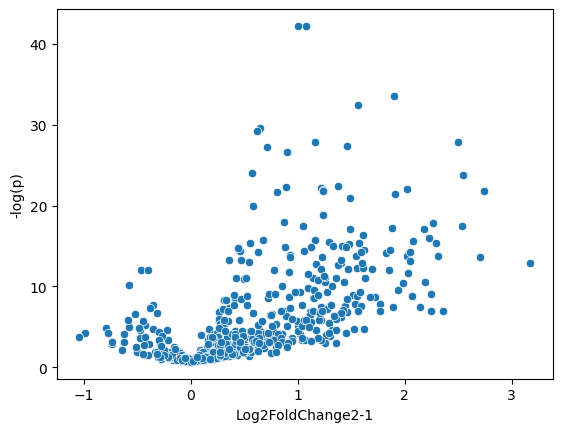

In [43]:
sns.scatterplot(
    data=quantified_data.row_annotations,
    x="Log2FoldChange2-1",
    y="-log(p)"
)

In [74]:
quantified_data.row_annotations['InverseRank2-1'] = 1 / quantified_data.row_annotations['MeanRank2-1']

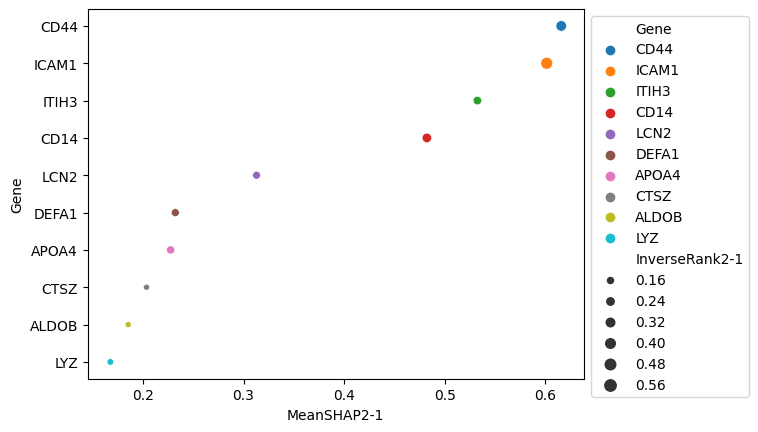

In [77]:
ax = sns.scatterplot(
    data=quantified_data.row_annotations.sort_values("MeanSHAP2-1", ascending=False).head(10),
    x="MeanSHAP2-1",
    y="Gene",
    hue="Gene",
    size="InverseRank2-1",
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

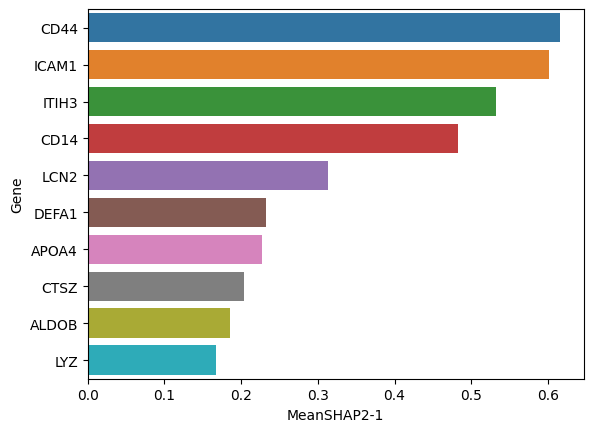

In [79]:
ax = sns.barplot(
    data=quantified_data.row_annotations.sort_values("MeanSHAP2-1", ascending=False).head(10),
    x="MeanSHAP2-1",
    y="Gene",
    hue_order="Gene",
)

<Axes: xlabel='MeanSHAP2-1', ylabel='-log(p)'>

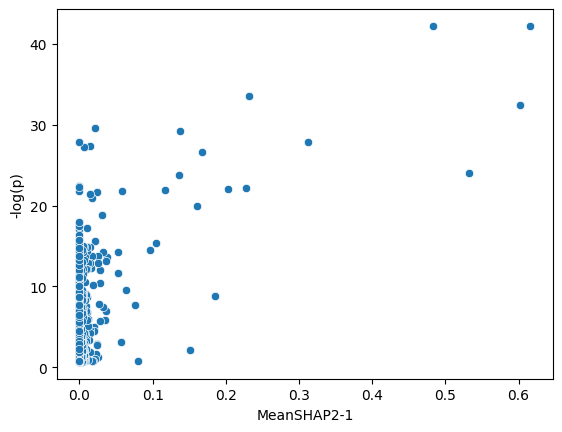

: 

In [80]:
sns.scatterplot(
    data=quantified_data.row_annotations.sort_values("MeanSHAP2-1", ascending=False),
    y="-log(p)",
    x="MeanSHAP2-1",
)